In [1]:
# Change Python path
import os, sys
os.chdir("/LOCALDATA/ARTHURs_FILES/Codigos/")
print(os.getcwd())
sys.path.append('python_modules')

# Enables modules autoreload (important during development)
%load_ext autoreload
%autoreload 2

/LOCALDATA/ARTHURs_FILES/Codigos


## SSTA Distribution

In [2]:
from data_managers.load_save_cmems_sst import load_cmems_sst

# Loading Dataset
ds_cmems_sst = load_cmems_sst(
    # years=range(2009, 2014),
    # lon_selector=slice(2, 2.10),
    # lat_selector=slice(39, 39.1)
    region_selector="balears"
)

ds_cmems_sst

Loaded CMEMS-SST dataset.


<xarray.Dataset> Size: 508MB
Dimensions:  (time: 15340, lat: 69, lon: 120)
Coordinates:
  * lat      (lat) float32 276B 37.65 37.7 37.75 37.8 ... 40.96 41.01 41.06
  * lon      (lon) float32 480B -0.8591 -0.8091 -0.7591 ... 4.996 5.046 5.096
  * time     (time) datetime64[ns] 123kB 1982-01-01 1982-01-02 ... 2023-12-31
Data variables:
    T        (time, lat, lon) float32 508MB dask.array<chunksize=(31, 69, 120), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                CF-1.4 
    title:                      Mediterranean Sea SST Analysis L4, Reprocesse...
    summary:                    [1982-2018] Daily gap-free maps (L4) at 0.05d...
    references:                 A. Pisano, B. Buongiorno Nardelli, C. Troncon...
    institution:                GOS
    history:                    Mon Jun 10 12:26:11 2024: ncrcat 198201010000...
    ...                         ...
    publisher_name:             CNR ISMAR GOS - CMEMS SST-TAC
    publisher_url:              http://marine.copernicus.eu/
    publisher_email:            servicedesk.cmems@mercator-ocean.eu, gsdk@isa...
    processing_level:           L4
    cdm_data_type:              grid
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...

In [3]:
# Load climatology and calculate SSTA

from data_managers.load_save_cmems_sst import load_cmems_sst_clim

ds_clim = load_cmems_sst_clim(
    clim_year_start = int(ds_cmems_sst["time.year"].min().values),
    clim_year_end   = int(ds_cmems_sst["time.year"].max().values),
    region="balears"
)

# Add dayofyear coordinate to cmems_sst
ds_cmems_sst_doy = ds_cmems_sst.assign_coords(dayofyear = ds_cmems_sst['time.dayofyear'])

# Difference between cmems_sst and climatology
ds_ssta = ds_cmems_sst_doy.groupby('dayofyear') - ds_clim
ds_ssta

Loaded CMEMS-SST climatology.


<xarray.Dataset> Size: 508MB
Dimensions:    (lat: 69, lon: 120, time: 15340)
Coordinates:
  * lat        (lat) float32 276B 37.65 37.7 37.75 37.8 ... 40.96 41.01 41.06
  * lon        (lon) float32 480B -0.8591 -0.8091 -0.7591 ... 4.996 5.046 5.096
  * time       (time) datetime64[ns] 123kB 1982-01-01 1982-01-02 ... 2023-12-31
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
Data variables:
    T          (time, lat, lon) float32 508MB dask.array<chunksize=(1, 69, 120), meta=np.ndarray>

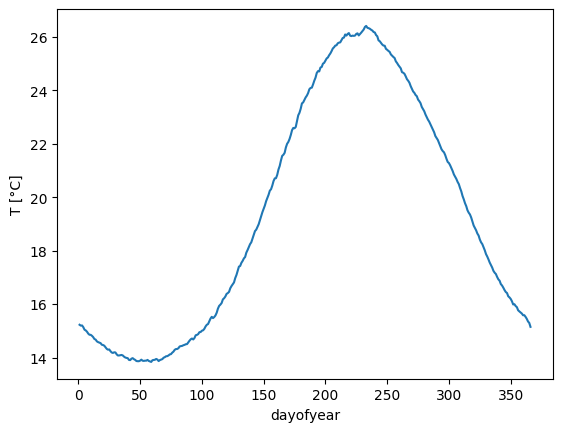

In [4]:
# Plot climatology

ds_mean = ds_clim.mean(dim=["lon","lat"], keep_attrs=True)
ds_mean.T.plot()

In [15]:
ds_ssta

<xarray.Dataset> Size: 508MB
Dimensions:    (lat: 69, lon: 120, time: 15340)
Coordinates:
  * lat        (lat) float32 276B 37.65 37.7 37.75 37.8 ... 40.96 41.01 41.06
  * lon        (lon) float32 480B -0.8591 -0.8091 -0.7591 ... 4.996 5.046 5.096
  * time       (time) datetime64[ns] 123kB 1982-01-01 1982-01-02 ... 2023-12-31
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
Data variables:
    T          (time, lat, lon) float32 508MB dask.array<chunksize=(1, 69, 120), meta=np.ndarray>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from dask.diagnostics import ProgressBar

year_span = 3
for years in [[1982, 1985], [2018, 2021]]:
    with plt.rc_context({'font.size': 18}):
        plt.figure()

        for i, year_start in enumerate(years):
            year_end = year_start + year_span - 1
            da = ds_ssta.sel(time=slice(f"{year_start}-01-01", f"{year_end}-12-31")).T
            # da = da.isel(lon=5, lat=5)
            da = da.mean(dim=["lon","lat"], keep_attrs=True)
            
            print(year_start, year_end)
            
            with ProgressBar():
                da = da.values.flatten()
            
            color = ["#DA3226CC", "#2665DACC", "#54BD23CC", "#A926D1CC"][i]
            
            plt.hist(da, 15, density=True, label=year_start if year_span==1 else f"{year_start}-{year_end}", alpha=0.8, color=color)

            plt.vlines(np.nanquantile(da, 0.1), ymin=0, ymax=1, linestyles="--", color=color)
            plt.vlines(np.nanmedian(da), ymin=0, ymax=1, color=color)
            plt.vlines(np.nanquantile(da, 0.9), ymin=0, ymax=1, linestyles="--", color=color)
            # plt.vlines(da.quantile(0.1).values, ymin=0, ymax=1, linestyles="--", color=color)
            # plt.vlines(da.median().values, ymin=0, ymax=1, color=color)
            # plt.vlines(da.quantile(0.9).values, ymin=0, ymax=1, linestyles="--", color=color)

        plt.ylim(0, 0.7)
        plt.xlim(-5, 5)
        plt.ylabel("Density")
        plt.xlabel("SSTA [°C]")
        # plt.title("SSTA distribution\n (averaged over Balearic region)")

        plt.legend()
plt.show()

1982 1984
[########################################] | 100% Completed | 5.20 sms
1985 1987
[########################################] | 100% Completed | 5.50 sms
2018 2020
[########################################] | 100% Completed | 4.53 sms
2021 2023
[########################################] | 100% Completed | 3.93 sms


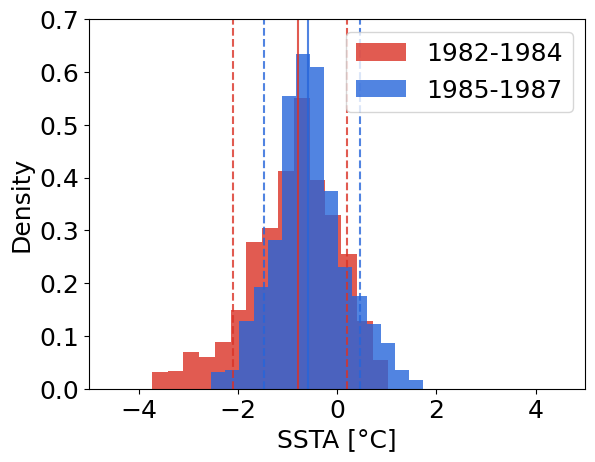

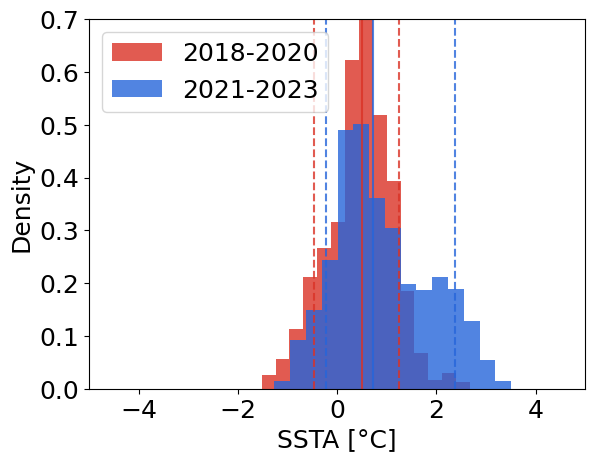

In [6]:
plt.show()

In [40]:
from dask.diagnostics import ProgressBar

def plot_distrib(da, ax, ds_ssta, year_ranges, **kwargs):
    ...
    for i, (year_start, year_end) in enumerate(year_ranges):
        print(year_start, year_end)
        # da = ds_ssta.sel(time=slice(f"{year_start}-01-01", f"{year_end}-12-31")).T
        # da = da.mean(dim=["lon","lat"], keep_attrs=True)
        
        # with ProgressBar():
        #     da = da.compute()
        
        color = ["#DA3226CC", "#2665DACC", "#54BD23CC", "#A926D1CC"][i]
        
        ax.hist(da, 10, density=True, label=year_start if year_start==year_end else f"{year_start}-{year_end+2}", alpha=0.8, color=color)

        ax.vlines(da.quantile(0.1).values, ymin=0, ymax=1, linestyles="--", color=color)
        ax.vlines(da.median().values, ymin=0, ymax=1, color=color)
        ax.vlines(da.quantile(0.9).values, ymin=0, ymax=1, linestyles="--", color=color)

    ax.set_ylim(0, 0.7)
    ax.set_ylabel("Density")
    ax.set_xlabel("SSTA [°C]")
    ax.set_title("SSTA distribution averaged over the Balearic region")

    ax.legend()

In [14]:
da = ds_ssta.sel(time=slice(f"{1982}-01-01", f"{1982}-12-31")).T
da = da.mean(dim=["lon","lat"], keep_attrs=True)

with ProgressBar():
    da = da.compute()

[########################################] | 100% Completed | 49.98 s


1982 1984
1985 1987
2018 2020
2021 2023


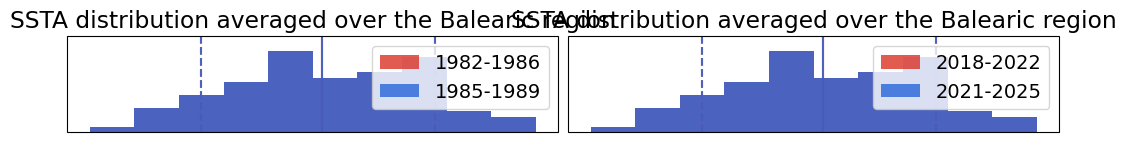

In [42]:
from data_plotters.basic_plotting import subplot

nb_years = 3

subplot(
    (2, 2),
    [
        dict(
            pos = i+1,
            func = plot_distrib,
            ds_ssta = ds_cmems_sst,
            da=da,
            year_ranges = [
                [year, year+nb_years-1],
                [year+nb_years, year+nb_years*2-1]
            ]
        ) for i, year in enumerate([1982, 2023-nb_years*2+1])
    ],
    figsize=(10,20),
    # fig_title="a",
    show_plots=True
)